In [1]:
%matplotlib notebook
from networkx.algorithms import community
from tqdm import tqdm
from matplotlib import style
import networkx as nix
import matplotlib.pyplot as plt
import gensim
import requests
import os
import collections
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)
style.use('ggplot')

In [2]:
# Downloads the binary from RusVectores
def download_file(url):
    # code partially taken from StackOverflow
    filename = url.split('/')[-1]
    print('It takes about 10 minutes to download the binary')
    file = requests.get(url, allow_redirects=True)
    with open(filename, 'wb') as f:
        f.write(file.content)
    return filename


# Searching the directory for a bin.gz binary
def checking_for_file():
    directory = os.listdir(os.getcwd())
    for i in directory:
        if i.endswith('vec.gz') or i.endswith('bin.gz'):
            print('Already have the binary')
            return i
    print('Downloading the binary')
    # I'm using this binary as it's the last mystem-based one
    m = download_file("http://rusvectores.org/static/models/"
                      "rusvectores2/ruscorpora_mystem_cbow_300_2_2015.bin.gz")
    print('Got it')
    return m

In [3]:
# Makes a tuple (word1, word2, their cosine distance)
def building_a_dict(m):
    if m.endswith('bin.gz'):
        model = gensim.models.KeyedVectors.load_word2vec_format(m,
                                                                binary=True)
    elif m.endswith('vec.gz'):
        model = gensim.models.KeyedVectors.load_word2vec_format(m,
                                                                binary=False)
    else:
        print('Unable to read vector space')
        return None
    # поле - птицы!
    words = ['птица_S', 'ястреб_S', 'утка_S']
    tup = []
    for word in words:
        if word in model:
            #  ближайшие соседи
            for i in tqdm(model.most_similar(positive=[word], topn=10**8)):
                if i[1] >= 0.5 and i[0].endswith('_S'):
                    # слово1, слово2, близость
                    tup.append((word[:-2], i[0][:-2], i[1]))
                    for k in model.most_similar(positive=[i[0]], topn=10**8):
                        # ближайшие соседи к соседям
                        if k[1] >= 0.5 and k[0].endswith('_S'):
                            tup.append((i[0][:-2], k[0][:-2], k[1]))
        else:
            print('Слова "%s" нет в модели' % word)
    return tup


# Makes a weighted graph from said tuple
def making_a_graph(tup):
    g = nix.Graph()
    for item in tup:
        if item[0][:-2] not in g:
            g.add_node(item[0], label=item[0])
        if item[1] not in g:
            g.add_node(item[1], label=item[1])
        g.add_edge(item[0], item[1], weight=10 * round(item[2], 5))
    return g

In [4]:
# Counting the graph's centrality and other metrics
def metrics(g):
    print('Метрики графа: центральность, плотность, диаметр, '
          'радиус, коэффициент кластеризации и ассортативности')
    dgr = collections.Counter(nix.degree_centrality(g)).most_common(1)
    print('Узел с наивысшей degree centrality:',
          dgr[0][0], ',', dgr[0][1])
    btw = collections.Counter(nix.betweenness_centrality(g)).most_common(1)
    print('Узел с наивысшей betweenness centrality:',
          btw[0][0], ',', btw[0][1])
    cls = collections.Counter(nix.closeness_centrality(g)).most_common(1)
    print('Узел с наивысшей closeness centrality:',
          cls[0][0], ',', btw[0][1])
    # don't understand the diff between this and basic eig centrality
    eig = collections.Counter(nix.eigenvector_centrality_numpy(g))
    eig = eig.most_common(1)
    print('Узел с наивысшей eigencentrality:',
          eig[0][0], ',', eig[0][1])
    print('Плотность графа:', nix.density(g))
    print('Диаметр графа:', nix.diameter(g))
    print('Радиус графа:', nix.radius(g))
    print('Коэффициент кластеризации:', nix.average_clustering(g))
    print('Коэффициент ассортативности:',
          nix.degree_pearson_correlation_coefficient(g))

In [5]:
# Got the function from StackOverflow
# Source: https://bit.ly/2JOyeGc
def get_cmap(n, name='hsv'):
    """Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
     RGB color; the keyword argument name must be
     a standard mpl colormap name."""
    return plt.cm.get_cmap(name, n)


# Divides the graph into communities
def communities(g):
    # modularity-based approach
    com = community.greedy_modularity_communities(g, weight='weight')
    com = sorted(com)
    print('Cообщества, выделенные в графе:')
    cmap = get_cmap(len(com))
    pretty_colours = []
    for i, item in enumerate(com):
        print('сообщество №', i+1, ':', tuple(item))
        pretty_colours.append([tuple(item), cmap(i)])
    return pretty_colours

In [6]:
# Visualises the graph using matplotlib
def graph_visualisation(g, pretty_colours):
    pos = nix.spring_layout(g)
    node_d = []
    colour = []
    for node in g.nodes():
        node_d.append(g.degree(node)*20)
        for colorscheme in pretty_colours:
            if node in colorscheme[0]:
                colour.append(colorscheme[1])
    # размер - мощность графа, цвет - сообщества
    nix.draw_networkx_nodes(g, pos, node_color=colour, node_size=node_d)
    nix.draw_networkx_edges(g, pos, edge_color='grey')
    nix.draw_networkx_labels(g, pos, font_size=10, font_family='Consolas')
    plt.axis('off')
    nix.write_gexf(g, 'ptichki.gexf')
    plt.show()

Already have the binary


2019-05-31 16:53:23,619 : INFO : loading projection weights from ruscorpora_mystem_cbow_300_2_2015.bin.gz
2019-05-31 16:53:23,620 : WARNING : this function is deprecated, use smart_open.open instead
2019-05-31 16:53:34,106 : INFO : loaded (281776, 300) matrix from ruscorpora_mystem_cbow_300_2_2015.bin.gz
2019-05-31 16:53:34,107 : INFO : precomputing L2-norms of word weight vectors
100%|███████████████████████████████████████████████████████████████████████| 281775/281775 [00:06<00:00, 44207.58it/s]


Метрики графа: центральность, плотность, диаметр, радиус, коэффициент кластеризации и ассортативности
Узел с наивысшей degree centrality: птица , 0.23076923076923078
Узел с наивысшей betweenness centrality: птица , 0.42285146550510794
Узел с наивысшей closeness centrality: птица , 0.42285146550510794
Узел с наивысшей eigencentrality: птица , 0.39463623815121296
Плотность графа: 0.026902059688944935
Диаметр графа: 5
Радиус графа: 3
Коэффициент кластеризации: 0.38095393617444084
Коэффициент ассортативности: -0.24472907039905387
Cообщества, выделенные в графе:
сообщество № 1 : ('муха', 'папильон', 'капустница', 'лимонница', 'траурница', 'бабочка', 'ночница', 'нетопырь', 'фламинго', 'шмель', 'оса', 'мотылек', 'стрекоза')
сообщество № 2 : ('зверушка', 'зверек', 'обезьянка', 'грызун', 'мышонок', 'звереныш', 'котенок', 'лисица', 'кролик', 'волчонок', 'зверюшка', 'собачонка')
сообщество № 3 : ('животное', 'жук', 'микроб', 'насекомое', 'ящерица', 'грызунов', 'личинка', 'пчела', 'паук', 'комар',

<IPython.core.display.Javascript object>


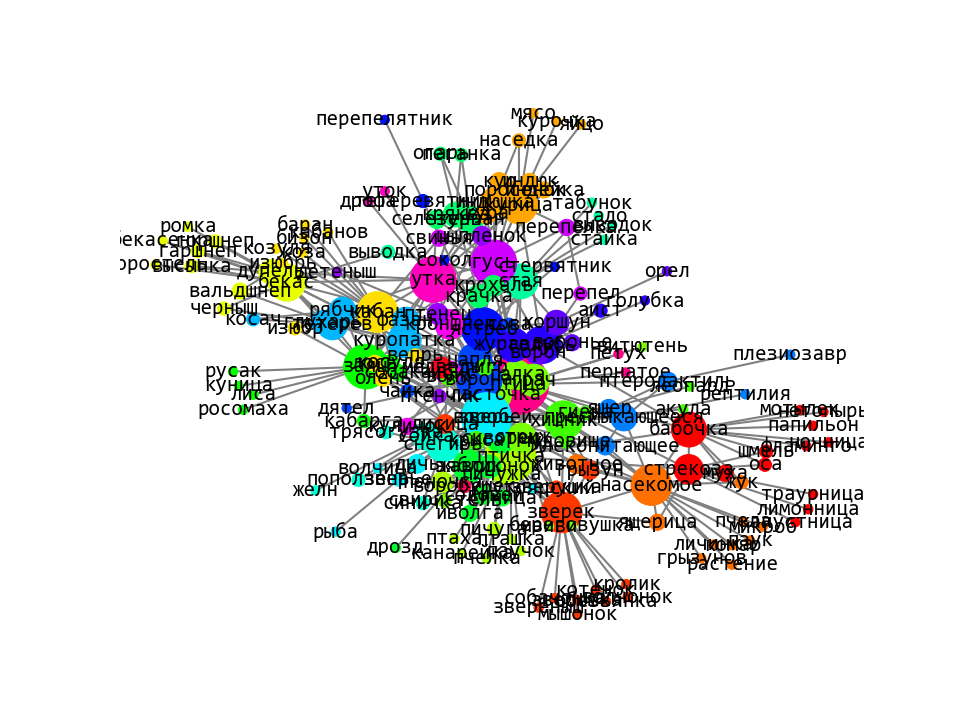

C:\Users\mi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [7]:
def main():
    m = checking_for_file()
    tup = building_a_dict(m)
    g = making_a_graph(tup)
    metrics(g)
    pretty_colours = communities(g)
    graph_visualisation(g, pretty_colours)


if __name__ == '__main__':
    main()

Интерпретация сообществ: довольно чётко выделяются насекомые ('бабочка, стрекоза, муха'), классы животных ("грызун, зверек"), а также домашние животные ('индейка, курица'). Таргетное поле - птицы - выделяется отдельными группами (вальдшнеп получается не в том же сообществе, что и жаворонок или трясогузка). Интерпретировать полученные данные довольно трудно, но в целом летающие существа чаще находятся в одной группе, чем нелетающие.